In [55]:
# import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)

In [56]:
# data parameters
risky_assets = ['MSFT', 'AAPL', 'NVDA', 'AVGO', 'CRM', 'AMD', 'ADBE']
n_monto_carlo = 10 ** 5
start_date = '2023-10-25'
end_date = '2024-05-31'
n_assets = len(risky_assets)

In [57]:
# download the data
prices_df = yf.download(risky_assets, start=start_date, end=end_date)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
N_DAYS = prices_df.shape[0]
prices_df.head(3)

[*********************100%%**********************]  7 of 7 completed

Downloaded 150 rows of data.


Price        Adj Close                                                 \
Ticker            AAPL        ADBE        AMD        AVGO         CRM   
Date                                                                    
2023-10-25  170.657120  521.140015  96.059998  842.154541  196.802917   
2023-10-26  166.458008  514.280029  93.669998  819.475891  195.993973   
2023-10-27  167.784561  508.119995  96.430000  830.983765  196.313568   

Price                                   Close                         ...  \
Ticker            MSFT       NVDA        AAPL        ADBE        AMD  ...   
Date                                                                  ...   
2023-10-25  338.741425  41.769936  171.100006  521.140015  96.059998  ...   
2023-10-26  326.033783  40.317253  166.889999  514.280029  93.669998  ...   
2023-10-27  327.942902  40.491215  168.220001  508.119995  96.430000  ...   

Price             Open                           Volume                     \
Ticker             CRM        MSFT       NVDA      AAPL     ADBE       AMD   
Date                                                                         
2023-10-25  203.199997  345.019989  43.397999  57157000  2526000  53424500   
2023-10-26  197.419998  340.540009  41.853001  70625300  2876700  49896400   
2023-10-27  197.300003  330.429993  41.130001  58499100  2985600  52458700   

Price                                              
Ticker         AVGO      CRM      MSFT       NVDA  
Date                                               
2023-10-25  2143200  4490000  55053800  398379000  
2023-10-26  2791700  5149100  37828500  541001000  
2023-10-27  1823600  3168600  29856500  416784000  

[3 rows x 42 columns]

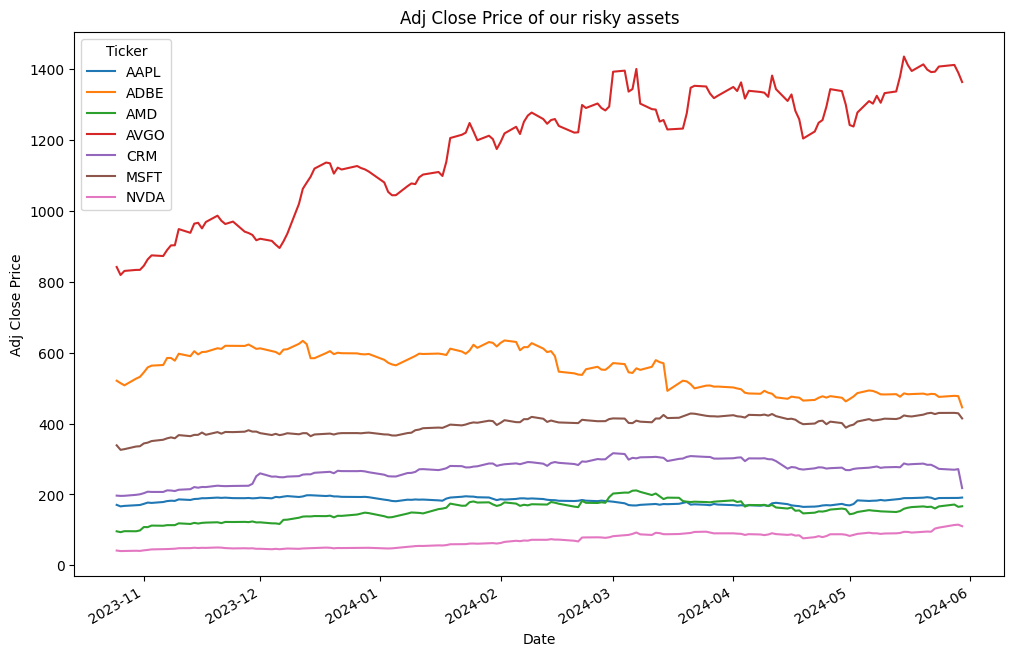

In [58]:
# choose Adj Close
prices_df['Adj Close'].plot(title='Adj Close Price of our risky assets')
plt.ylabel('Adj Close Price')
plt.show()

In [59]:
# caculate the percentage returns
returns_df = prices_df['Adj Close'].pct_change().dropna()
returns_df.head()

Ticker,AAPL,ADBE,AMD,AVGO,CRM,MSFT,NVDA
Date,,,,,,,
2023-10-26,-0.024606,-0.013163,-0.024880,-0.026929,-0.004110,-0.037514,-0.034778
2023-10-27,0.007969,-0.011978,0.029465,0.014043,0.001631,0.005856,0.004315
2023-10-30,0.012305,0.037039,-0.002593,0.003447,0.013736,0.022740,0.016321
2023-10-31,0.002819,0.009716,0.024121,0.000143,0.007829,0.002372,-0.009256
2023-11-01,0.018739,0.023381,0.096853,0.013751,0.015336,0.023543,0.037886


# 平均回报率和协方差矩阵

In [60]:
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
avg_returns, cov_mat

(Ticker
 AAPL    0.127883
 ADBE   -0.122527
 AMD     0.626466
 AVGO    0.525666
 CRM     0.148526
 MSFT    0.215394
 NVDA    1.045953
 dtype: float64,
 Ticker      AAPL      ADBE       AMD      AVGO       CRM      MSFT      NVDA
 Ticker                                                                      
 AAPL    0.026174  0.010017  0.016722  0.013488  0.010311  0.011191  0.012995
 ADBE    0.010017  0.066959  0.028095  0.028470  0.037128  0.023291  0.029054
 AMD     0.016722  0.028095  0.142834  0.064002  0.027422  0.023595  0.083417
 AVGO    0.013488  0.028470  0.064002  0.080104  0.030845  0.021222  0.061546
 CRM     0.010311  0.037128  0.027422  0.030845  0.085682  0.022526  0.032025
 MSFT    0.011191  0.023291  0.023595  0.021222  0.022526  0.023393  0.026282
 NVDA    0.012995  0.029054  0.083417  0.061546  0.032025  0.026282  0.130497)

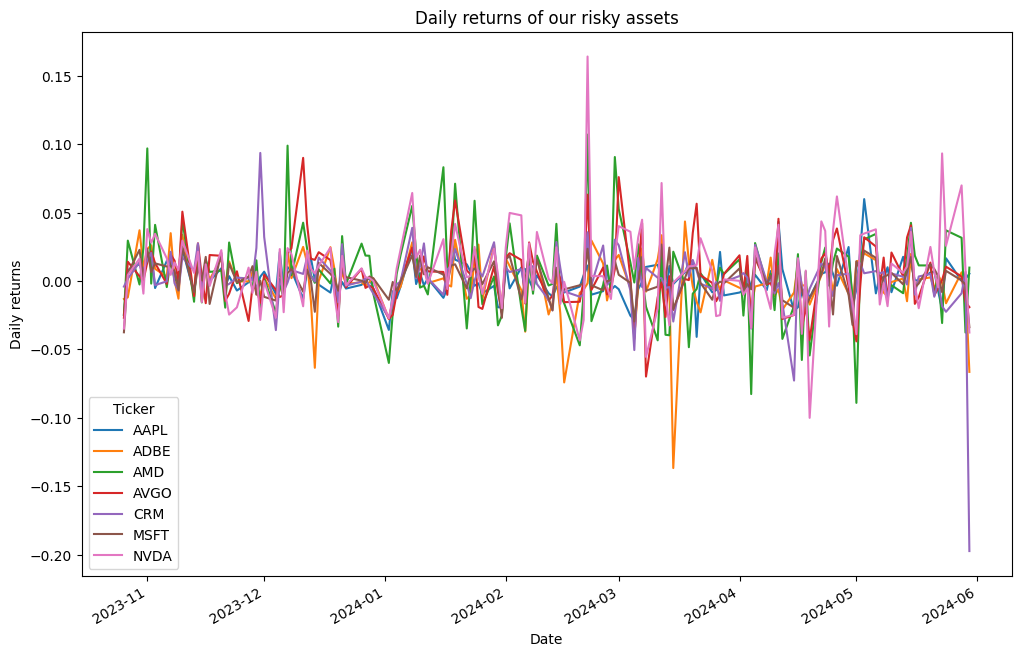

In [61]:
returns_df.plot(title='Daily returns of our risky assets')
plt.ylabel('Daily returns')
plt.show()

In [62]:
np.random.seed(666)
weights = np.random.random(size=(n_monto_carlo, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [63]:
portf_rtns = weights @ avg_returns

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(weights[i] @ cov_mat @ weights[i].T))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [64]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio': portf_sharpe_ratio})

In [65]:
n_internal = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), n_internal)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for index in range(n_internal):
    if portf_rtns_ef[index] not in portf_rtns:
        indices_to_skip.append(index)
        continue
    matched_index = np.where(portf_rtns == portf_rtns_ef[index])
    portf_vol_ef.append(np.min(portf_vol[matched_index]))


# delete the inner dot
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

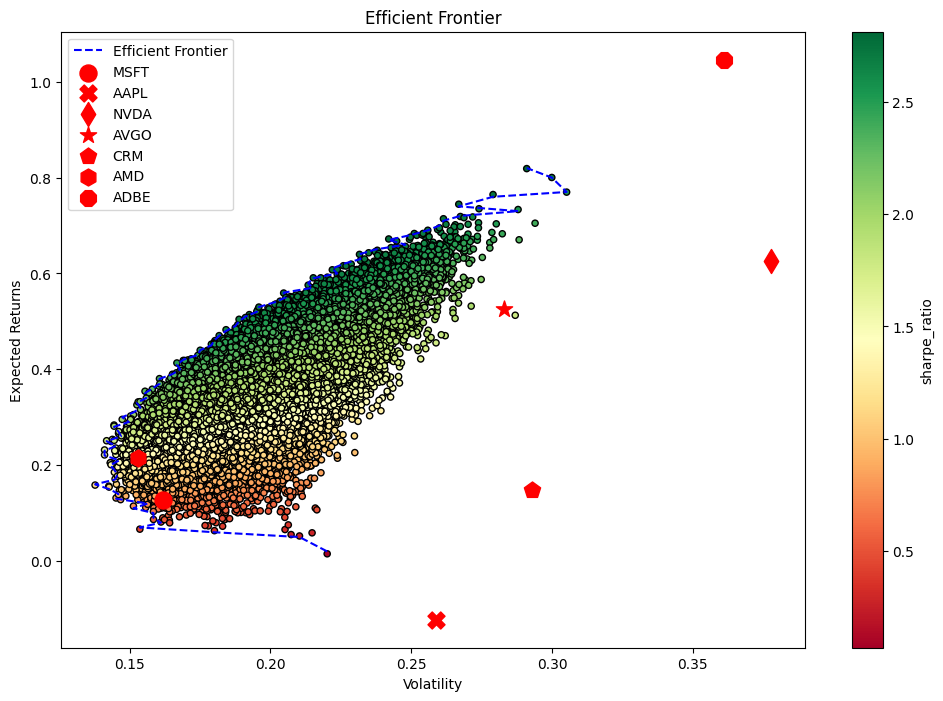

In [66]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
MARKS = ['o', 'X', 'd', '*', 'p', 'h', '8']
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_assets[asset_index])
ax.legend()
plt.show()

In [67]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [68]:
print('Maximum Sharpe Ratio portfolio --->')
print('Performance:')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_assets, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio --->
Performance:
returns: 81.87% volatility: 29.10% sharpe_ratio: 281.35% 
Weights:
MSFT: 5.04% AAPL: 0.89% NVDA: 9.84% AVGO: 0.63% CRM: 7.03% AMD: 7.57% ADBE: 69.00% 

In [69]:
print('Minimum Volatility portfolio --->')
print('Performance:')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_assets, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio --->
Performance:
returns: 15.84% volatility: 13.77% sharpe_ratio: 115.03% 
Weights:
MSFT: 36.86% AAPL: 12.69% NVDA: 0.82% AVGO: 0.28% CRM: 2.08% AMD: 45.43% ADBE: 1.84% 

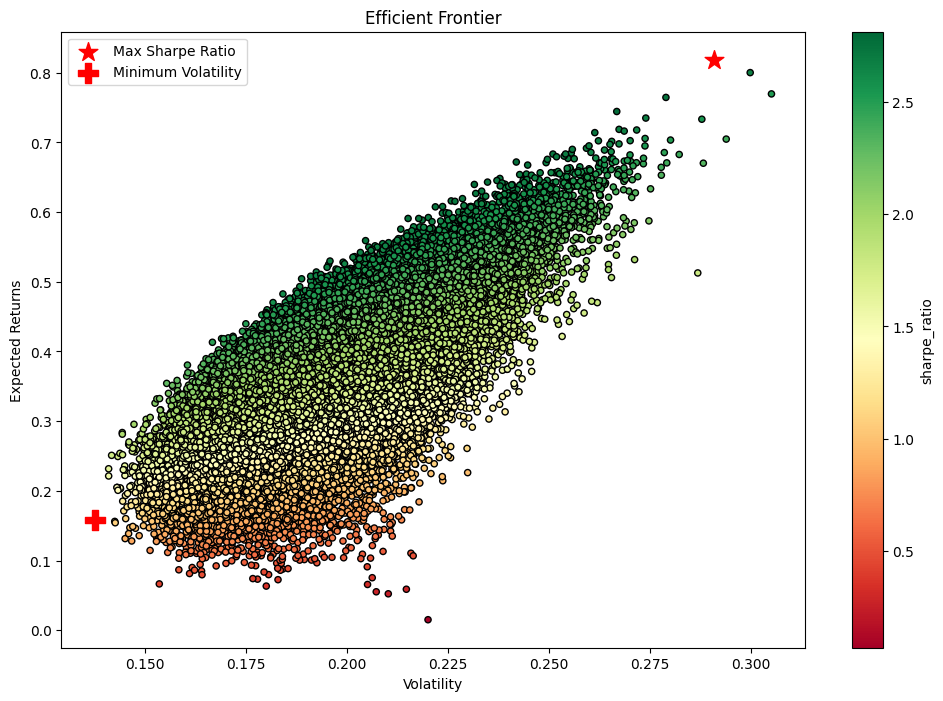

In [70]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns, 
           c='red', marker='*', s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns, 
           c='red', marker='P', s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.legend()
plt.show()

In [74]:
# 用预测的weight计算收益率
weight_predict = np.array([0.00359835, 0.18921126, 0.1048381 , 0.56119306, 0.0172781 , 0.01518241, 0.10869872])
ret = returns_df @ weight_predict.T
ret_pro = ret + 1
np.cumprod(ret_pro)

Date
2023-10-26    0.975279
2023-10-27    0.984367
2023-10-30    0.995266
2023-10-31    0.998871
2023-11-01    1.025943
                ...   
2024-05-23    1.561018
2024-05-24    1.575425
2024-05-28    1.597131
2024-05-29    1.578008
2024-05-30    1.530231
Length: 149, dtype: float64